In [1]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.preprocessing import MinMaxScaler, StandardScaler

In [ ]:
full_df = pd.read_csv("nuclei_membrane_tracking/full_manual_dataset.csv")

In [4]:
def normalize_dataframe(df, columns_to_normalize):
    # Create a copy of the dataframe
    df_normalized = df.copy()

    # Replace missing values with 0 in the selected columns
    #df_normalized[columns_to_normalize] = df_normalized[columns_to_normalize].fillna(0)

    # Normalize selected columns
    scaler = StandardScaler()
    scaled_values = scaler.fit_transform(df_normalized[columns_to_normalize].values)
    df_normalized[columns_to_normalize] = scaled_values

    return df_normalized

In [ ]:
selected_features = ['Local_Cell_Density',
 'Speed',
 'Motion_Angle_Z',
 'Motion_Angle_Y',
 'Motion_Angle_X',
 'Acceleration',
 'Distance_Cell_mask',
 'Radial_Angle_Z',
 'MSD',
 'nuc_Radius',
 'nuc_Eccentricity_Comp_First',
 'nuc_Eccentricity_Comp_Second',
 'nuc_Eccentricity_Comp_Third',
 'nuc_Cell_Axis_Z',
 'mem_Radius',
 'mem_Eccentricity_Comp_First',
 'mem_Eccentricity_Comp_Second',
 'mem_Eccentricity_Comp_Third',
 'mem_Surface_Area',
 'mem_Cell_Axis_Z',
 'mem_Radial_Angle_Z',
 'mem_2d_area',
 'mem_2d_eccentricity',
 'mem_2d_solidity',
 'mem_2d_extent',
 ]

In [19]:
plot_df = normalize_dataframe(full_df, selected_features)

In [ ]:
# Assuming your dataframe is named df and the list of feature columns is in a variable called all_features
df_avg = plot_df.groupby(['t_hours', 'cell_type'])[selected_features].mean().reset_index()


In [21]:
# Assuming your dataframe is named df and the list of feature columns is in a variable called all_features
df_avg_latent = plot_df.groupby(['t_hours', 'cell_type'])[latent].mean().reset_index()


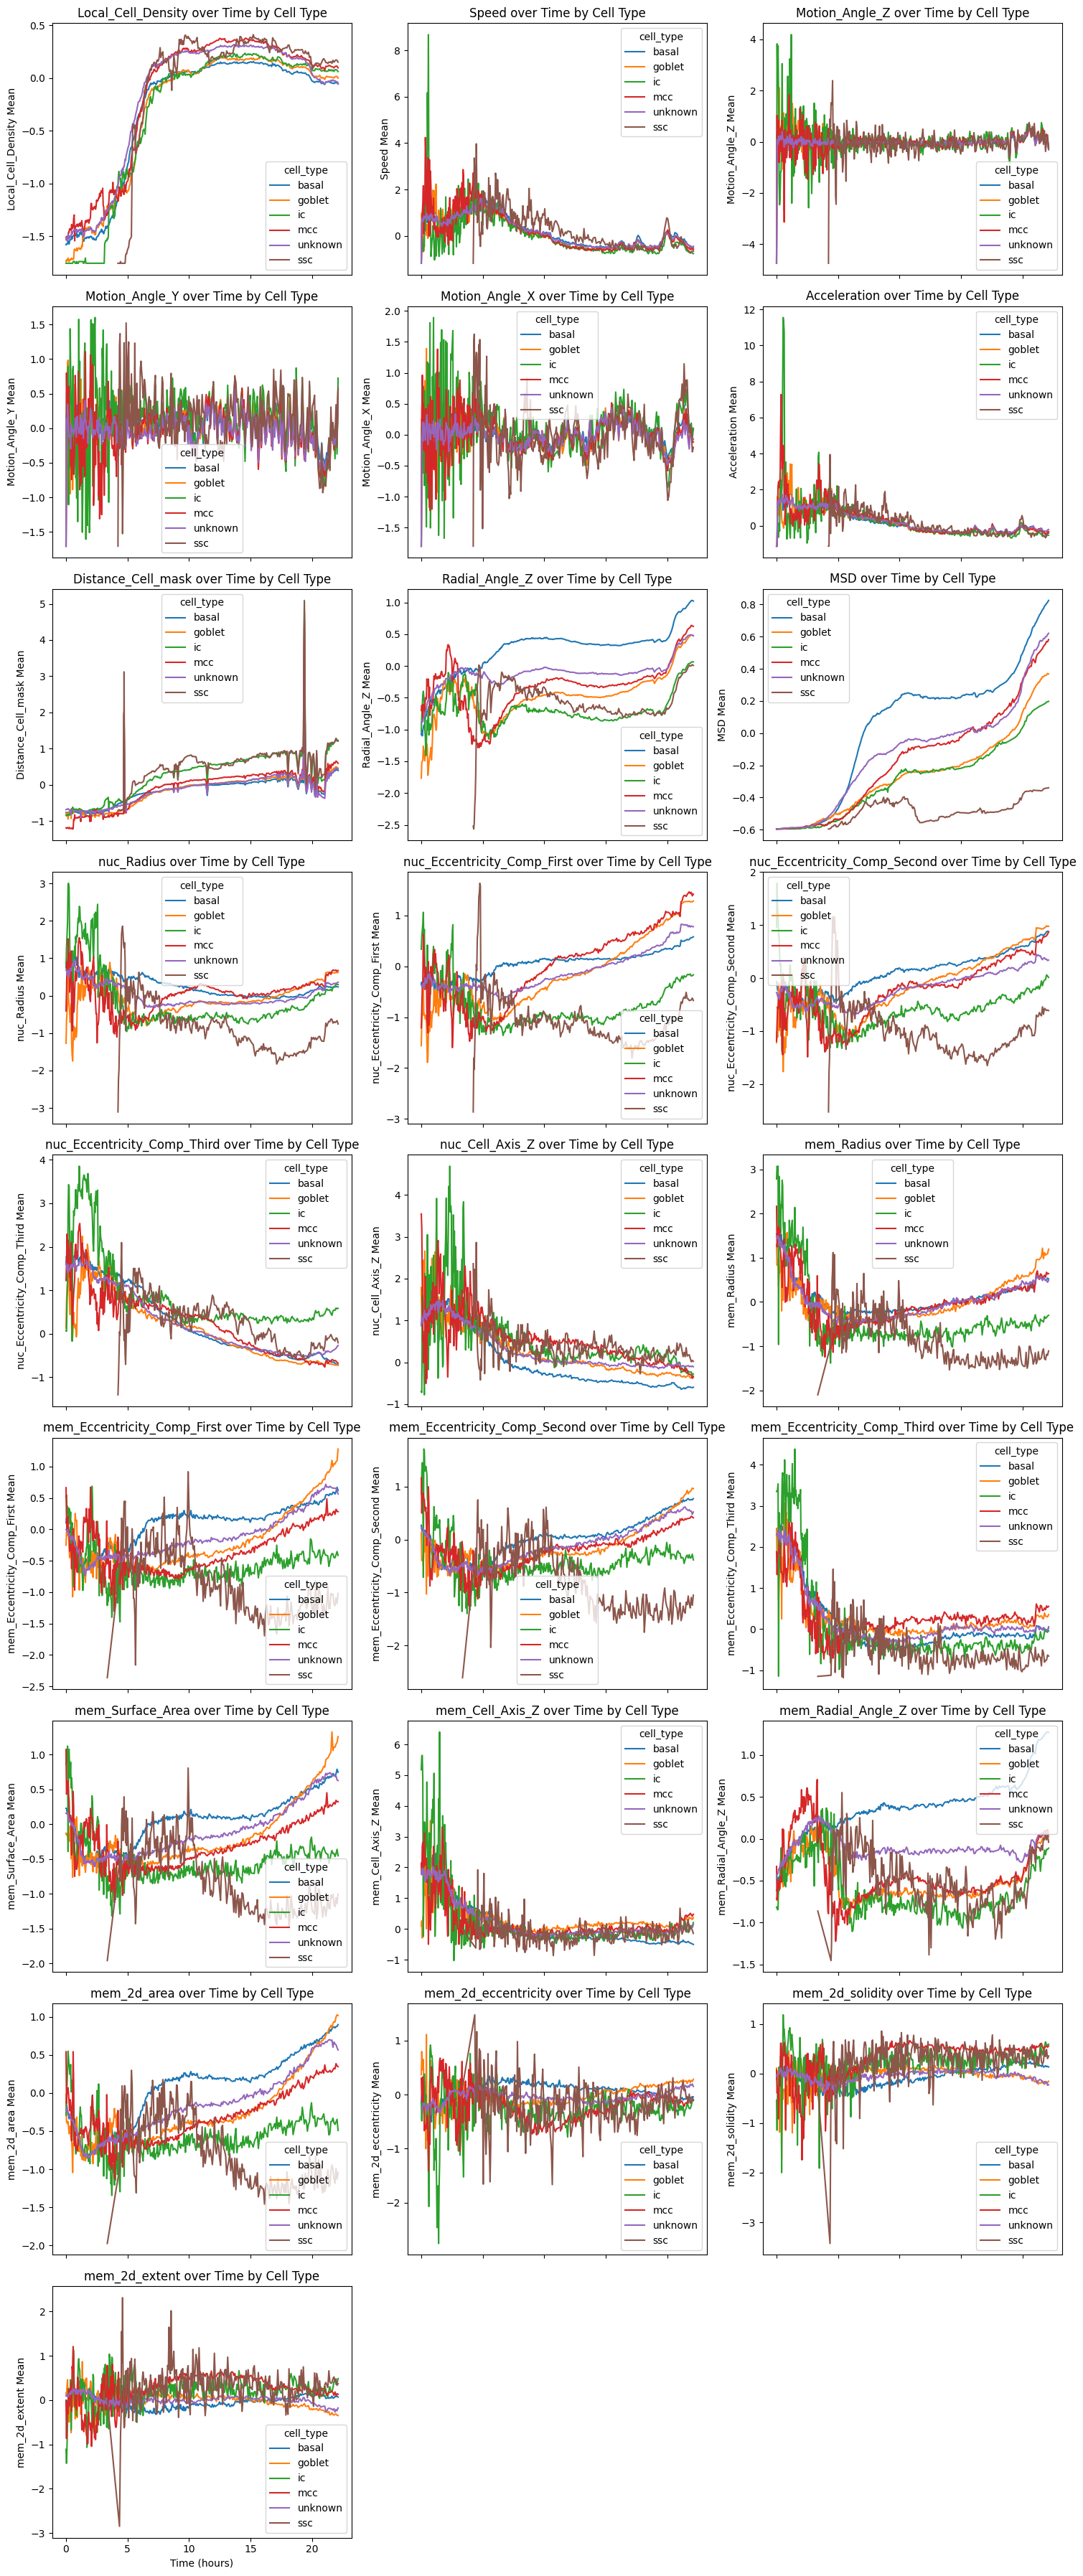

In [ ]:
# Define the number of rows and columns for the subplots grid
num_features = len(selected_features)
num_cols = 3  # You can adjust this to fit the layout better
num_rows = (num_features + num_cols - 1) // num_cols  # Calculate the number of rows needed

# Set up the figure and axes
fig, axes = plt.subplots(num_rows, num_cols, figsize=(15, num_rows * 4), sharex=True)
axes = axes.flatten()  # Flatten the array of axes to iterate over it easily

for i, feature in enumerate(selected_features):
    # Select the subplot axis
    ax = axes[i]

    # Use seaborn to create a line plot
    sns.lineplot(
        data=df_avg,
        x='t_hours', y=feature, hue='cell_type', ax=ax
    )

    # Set titles and labels
    ax.set_title(f'{feature} over Time by Cell Type')
    ax.set_xlabel('Time (hours)')
    ax.set_ylabel(f'{feature} Mean')

# Remove any empty subplots if num_features is less than nrows * ncols
for j in range(i + 1, len(axes)):
    fig.delaxes(axes[j])

# Adjust layout to prevent overlapping
plt.tight_layout()

# Show the plot
plt.show()

In [24]:
import numpy as np
from scipy.spatial.distance import pdist, cdist
from tqdm import tqdm

In [25]:
def calculate_within_class_distance(feature_array):
    if feature_array.shape[0] > 1:
        distances = pdist(feature_array, metric='euclidean')
        return distances.mean(), distances.std()
    else:
        return np.nan, np.nan

def calculate_between_class_distance(array_1, array_2):
    if array_1.shape[0] > 0 and array_2.shape[0] > 0:
        distances = cdist(array_1, array_2, metric='euclidean')
        return distances.mean(), distances.std()
    else:
        return np.nan, np.nan

In [26]:
plot_df2 = plot_df[plot_df['cell_type'] != 'unknown']

In [ ]:
# Initialize an empty list to store results
distance_data = []

# Get unique time points and cell types
time_points = plot_df2['t_hours'].unique()
cell_types = plot_df2['cell_type'].unique()

# Loop through each time point and cell type
for t in tqdm(time_points):
    df_time = plot_df2[plot_df2['t_hours'] == t]
    cell_types_time = df_time['cell_type'].unique()
    for cell_type in cell_types:
        if cell_type in cell_types_time:
            # Get features for current cell type
            df_within = df_time[df_time['cell_type'] == cell_type]
            features_within = df_within[selected_features].values
            features_within_clean = features_within[~np.isnan(features_within).any(axis=1)]

            # Calculate within-class distance
            within_mean, within_sd = calculate_within_class_distance(features_within_clean)
            
            # Get features for all other cell types at the same time point
            df_between = df_time[df_time['cell_type'] != cell_type]
            features_between = df_between[selected_features].values
            features_between_clean = features_between[~np.isnan(features_between).any(axis=1)]
            
            # Calculate between-class distance
            between_mean, between_sd = calculate_between_class_distance(features_within_clean, features_between_clean)
            
            # Append results to the list
            distance_data.append({
                't_hours': t,
                'cell_type': cell_type,
                'within_class_featuredistance_mean': within_mean,
                'within_class_featuredistance_sd': within_sd,
                'different_class_featuredistance_mean': between_mean,
                'different_class_featuredistance_sd': between_sd
            })
        else:
            # Append results to the list
            distance_data.append({
                't_hours': t,
                'cell_type': cell_type,
                'within_class_featuredistance_mean': np.nan,
                'within_class_featuredistance_sd': np.nan,
                'different_class_featuredistance_mean': np.nan,
                'different_class_featuredistance_sd': np.nan
            })

# Create a new DataFrame from the list
distance_df = pd.DataFrame(distance_data)


100%|██████████| 360/360 [00:18<00:00, 19.61it/s]


In [29]:
distance_df.sort_values(by = 't_hours', inplace=True, ignore_index=True)

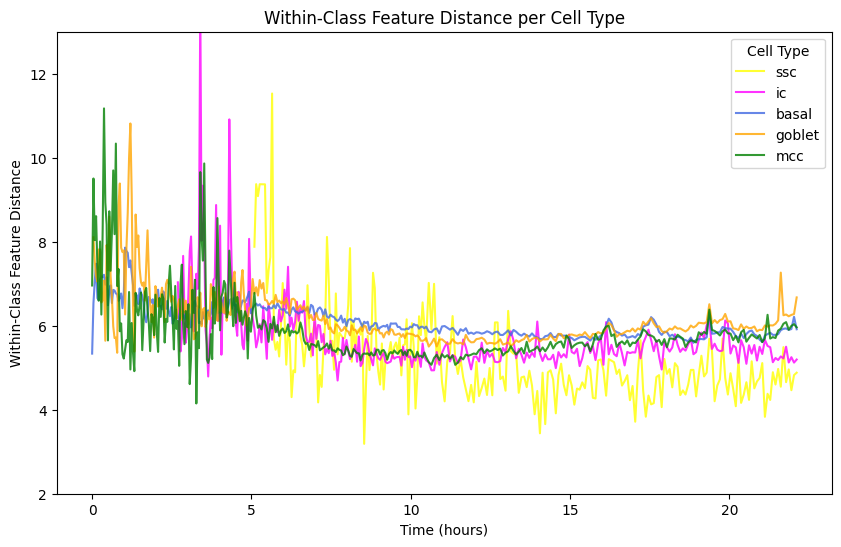

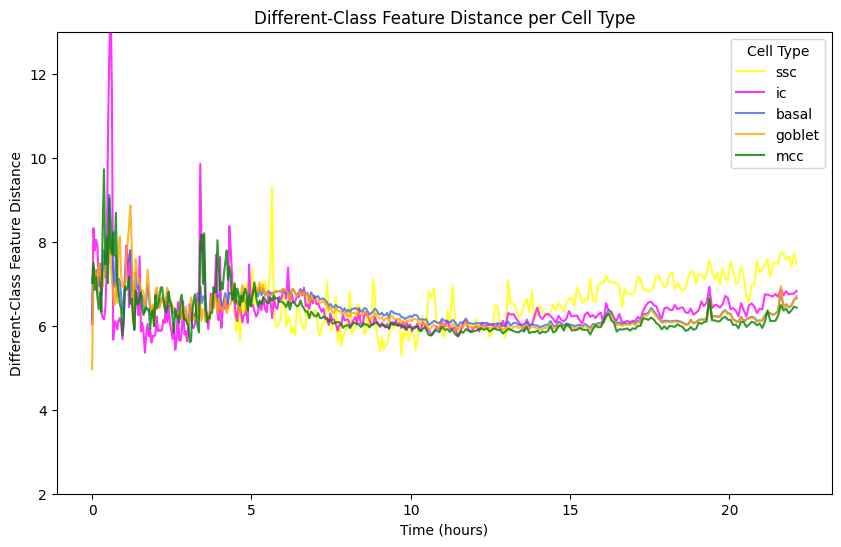

In [31]:
colors_dict = {'basal' : 'royalblue', 'goblet' : 'orange', 'ic' : 'magenta', 'mcc' : 'green', 'ssc' : 'yellow'}

# Set up a figure for plotting within-class distances
plt.figure(figsize=(10, 6))

# Plot within-class feature distances
sns.lineplot(data=distance_df, x='t_hours', y='within_class_featuredistance_mean', hue='cell_type', alpha=0.8, palette=colors_dict)
#plt.fill_between(distance_df['t_hours'], 
#                 distance_df['within_class_featuredistance_mean'] - distance_df['within_class_featuredistance_sd'],
#                 distance_df['within_class_featuredistance_mean'] + distance_df['within_class_featuredistance_sd'], alpha=0.2)
plt.title("Within-Class Feature Distance per Cell Type")
plt.xlabel("Time (hours)")
plt.ylabel("Within-Class Feature Distance")
plt.ylim(2,13)
plt.legend(title="Cell Type")
plt.show()

# Set up a figure for plotting different-class distances
plt.figure(figsize=(10, 6))

# Plot different-class feature distances
sns.lineplot(data=distance_df, x='t_hours', y='different_class_featuredistance_mean', hue='cell_type', alpha=0.8, palette=colors_dict)
#plt.fill_between(distance_df['t_hours'], 
#                 distance_df['different_class_featuredistance_mean'] - distance_df['different_class_featuredistance_sd'],
#                 distance_df['different_class_featuredistance_mean'] + distance_df['different_class_featuredistance_sd'], alpha=0.2)
plt.title("Different-Class Feature Distance per Cell Type")
plt.xlabel("Time (hours)")
plt.ylabel("Different-Class Feature Distance")
plt.ylim(2,13)
plt.legend(title="Cell Type")
plt.show()
